Please upload an image for classification:


Saving 0006do.png to 0006do.png
Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Loading pretrained DenseNet121 feature extractor...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting features from training set...
782/782 ━━━━━━━━━━━━━━━━━━━━ 184s 228ms/step
Extracting features from testing set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step
Training kNN classifier...
Evaluating kNN classifier...
Accuracy on CIFAR-10 test set: 52.81%
Preprocessing input image...
Extracting features from input image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Classifying the image...
Predicted Class: dog


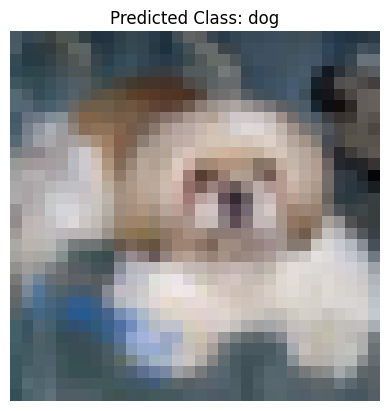

In [ ]:
import sys
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import files

# CIFAR-10 class labels
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def load_and_preprocess_image(image_path, target_size=(32, 32)):
    """
    Load and preprocess the input image for the CIFAR-10 classifier.

    Args:
        image_path (str): Path to the input image.
        target_size (tuple): Target size for resizing the image (32,32).

    Returns:
        np.ndarray: Preprocessed image ready for classification.
    """
    try:
        # Load and resize the image to the target size
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)  # Convert to NumPy array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array.astype('float32') / 255.0  # Normalize to [0, 1]
        return img_array
    except Exception as e:
        print(f"Error loading or preprocessing the image: {e}")
        sys.exit(1)

def load_feature_extractor():
    """
    Load DenseNet121 as a feature extractor, excluding its top layers.

    Returns:
        Model: Feature extractor model.
    """
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))
    return feature_extractor

def extract_features_and_train_classifier():
    """
    Extract features from the CIFAR-10 dataset using a pretrained DenseNet121 model
    and train a k-Nearest Neighbors (kNN) classifier on the extracted features.

    Returns:
        KNeighborsClassifier: Trained kNN classifier.
        feature_extractor: Feature extractor model (DenseNet121 without top layers).
    """
    print("Loading CIFAR-10 dataset...")
    # Load the CIFAR-10 dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Normalize the images to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Load the feature extractor (DenseNet121 without the top layers)
    print("Loading pretrained DenseNet121 feature extractor...")
    feature_extractor = load_feature_extractor()

    # Extract features for the training set
    print("Extracting features from training set...")
    x_train_features = feature_extractor.predict(x_train, batch_size=64, verbose=1)

    # Extract features for the testing set
    print("Extracting features from testing set...")
    x_test_features = feature_extractor.predict(x_test, batch_size=64, verbose=1)

    # Flatten the labels for use with sklearn
    y_train = y_train.flatten()
    y_test = y_test.flatten()

    # Train a k-Nearest Neighbors classifier on the extracted features
    print("Training kNN classifier...")
    knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
    knn.fit(x_train_features, y_train)

    # Evaluate the classifier on the testing set
    print("Evaluating kNN classifier...")
    accuracy = knn.score(x_test_features, y_test)
    print(f"Accuracy on CIFAR-10 test set: {accuracy * 100:.2f}%")

    return knn, feature_extractor

def classify_image(image_path, knn_classifier, feature_extractor):
    """
    Classify an image using the trained kNN classifier and the feature extractor.

    Args:
        image_path (str): Path to the input image.
        knn_classifier (KNeighborsClassifier): Trained kNN classifier.
        feature_extractor (Model): Feature extractor model.
    """
    # Preprocess the input image
    print("Preprocessing input image...")
    img_array = load_and_preprocess_image(image_path, target_size=(32, 32))

    # Extract features from the input image
    print("Extracting features from input image...")
    img_features = feature_extractor.predict(img_array)

    # Classify the image using the kNN classifier
    print("Classifying the image...")
    predicted_class_index = knn_classifier.predict(img_features)
    predicted_class_name = CLASS_NAMES[predicted_class_index[0]]

    # Output the prediction
    print(f"Predicted Class: {predicted_class_name}")

    # Display the uploaded image
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.show()


if __name__ == '__main__':
    print("Please upload an image for classification:")
    uploaded = files.upload()
    if not uploaded:
        print("No image uploaded. Exiting.")
    else:
        # Get the uploaded image path
        image_path = next(iter(uploaded))

        # Train the kNN classifier and load the feature extractor
        knn_classifier, feature_extractor = extract_features_and_train_classifier()

        # Classify the uploaded image
        classify_image(image_path, knn_classifier, feature_extractor)